In [171]:
%matplotlib inline

import matplotlib as mpl
import networkx as nx
import numpy as np
import random
import pandas as pd
import math
from copy import copy
from collections import defaultdict
from matplotlib import pyplot as plt
from itertools import combinations
from tqdm import tqdm
from joblib import Parallel, delayed

from graph_generators import grid_2d
from simulations import sample_graph_from_infection, simulate_IC, make_input
from plot_utils import add_colorbar, get_display_kwargs
from core import accuracy_for_nodes, experiment_multiple_rounds, normalize_mu, generate_sufficient_stats

In [101]:
# seed = 123456
# random.seed(seed)
# np.random.seed(seed)

In [169]:
infp = 0.7
g = grid_2d(10, infp)

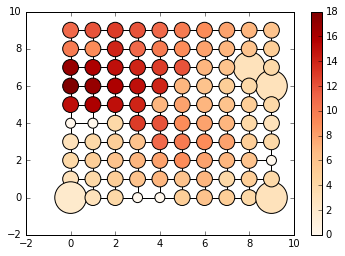

In [170]:
source, obs_nodes, infection_times, tree = make_input(g, infp, 0.05, sampling_method='late_nodes')
kwargs =get_display_kwargs(g, infection_times, obs_nodes=obs_nodes)
nx.draw_networkx(g, pos=pos, with_labels=False, **kwargs)
add_colorbar(kwargs['node_color'])

In [173]:
N = 250
# list of list of (source, times, tree)
stats = Parallel(n_jobs=-1)(delayed(generate_sufficient_stats)(g) for i in range(N))

In [174]:
# dict: node as source -> 2d matrix (infection time, node)
times_by_source = defaultdict(list)
for stat in stats:
    for s, times, _ in stat:
        times_array = np.array([times[n] for n in g.nodes_iter()])
        times_by_source[s].append(times_array)
times_by_source = {s: np.array(times2d)
                   for s, times2d in times_by_source.items()}

In [175]:
def mwu(g, source, obs_nodes, infection_times,
        times_by_source, 
        epsilon, 
        debug=False, plot=False,
        inspect_mu=False,
        max_plots=9):
    """
    times_by_source: sufficient statistics from each node (precomputed)
    """
    mu_of_source = []
    ### debugging START    
    if plot:
        pos = {n: np.array(n) for n in g.nodes()}
        ncols = 2
        nrows = math.ceil((max_plots) / ncols)
        width = 12
        height = int(width * nrows / ncols)
        fig, ax = plt.subplots(nrows, ncols,
                               sharex=True, sharey=True,
                               figsize=(width, height))
        kwargs = get_display_kwargs(g, infection_times, obs_nodes=obs_nodes)
        nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[0, 0], **kwargs)
        ax[0, 0].set_title('ground truth')
    ### debugging END
        
    node2id = {n: i for i, n in enumerate(g.nodes_iter())}
    mu = {n: 1 for n in g.nodes()}
    mu = normalize_mu(mu)
    mu_of_source.append(mu[source])

    query_count = 0
    queried_nodes = set()

    # using the observations
    for q in sorted(obs_nodes, key=lambda n: infection_times[n]):
        outcome = infection_times[q]
        acc = accuracy_for_nodes(q, outcome, times_by_source, node2id)
        for n, ac in acc.items():
            mu[n] *= np.power(1-epsilon, 1-ac)
        mu = normalize_mu(mu)
        queried_nodes.add(q)

    ### debugging START
    if debug:
        print_nodes_by_mu(g, mu, source)
        
    if plot and max_plots >= 1:
        i, j = 0, 1
        
        kwargs = get_display_kwargs(g, mu)
        likelihood_colors = [mu.get(n, 0) for n in g.nodes()]
        kwargs['node_color'] = likelihood_colors
        nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[i, j], **kwargs)
        ax[i, j].set_title('using observation')
    ### debugging END
        
    max_iter = float('inf')
    iter_i = 0

    all_nodes = set(g.nodes())
    while iter_i < max_iter:
        iter_i += 1
        
        if len(all_nodes - queried_nodes) == 0:
            if debug:
                print('no more nodes to query')
            break
            
        q = max(all_nodes - queried_nodes, key=lambda n: mu[n])
        queried_nodes.add(q)        
        query_count += 1

        if debug:
            print('query {}'.format(q))

        # if some node has very large mu
        # query its neighbors
        if not inspect_mu and max(mu.values()) > 0.1:
            s = max(mu, key=mu.__getitem__)
            if s not in queried_nodes:
                query_count += 1
                queried_nodes.add(s)
                
            is_source = np.all(list(map(lambda u: infection_times[s] < infection_times[u],
                                        g.neighbors(s))))
            unqueried_nodes = set(filter(lambda u: u not in queried_nodes, g.neighbors(s)))
            query_count += len(unqueried_nodes)
            queried_nodes |= unqueried_nodes
            if is_source:
                if debug:
                    print('**Found source')
                    print('used {} queries'.format(query_count))
                assert source == s
                break

        outcome = infection_times[q]
        acc = accuracy_for_nodes(q, outcome, times_by_source, node2id)
        for n, ac in acc.items():
            mu[n] *= np.power(1-epsilon, 1-ac)

        mu = normalize_mu(mu)    

        ### debugging START
        if plot and iter_i+2 <= max_plots:
            i, j = int((iter_i+1) / ncols), (iter_i+1) % ncols

            kwargs = get_display_kwargs(g, mu, obs_nodes={q})
            likelihood_colors = [mu.get(n, 0) for n in g.nodes()]
            kwargs['node_color'] = likelihood_colors
            nx.draw_networkx(g, pos=pos, with_labels=False, ax=ax[i, j], **kwargs)
            ax[i, j].set_title('iter_i={}'.format(iter_i))
        ### debugging END
        
        mu_of_source.append(mu[source])
        if debug:        
            print('iteration: {}'.format(iter_i))
            print_nodes_by_mu(g, mu, source)

    return query_count, mu_of_source

96


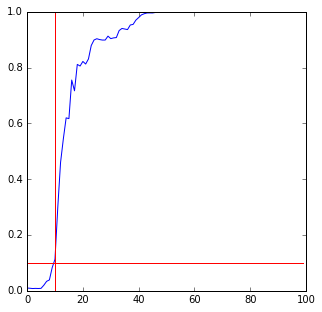

In [176]:
# demo of how mu(source increases)
source, obs_nodes, infection_times, tree = make_input(g, infp=0.7, fraction=0.05, sampling_method='late_nodes')
query_count, mu_of_source = mwu(g, source, obs_nodes, infection_times, times_by_source,
                                epsilon=0.7,
                                inspect_mu=True,
                                debug=False, 
                                plot=True,
                                max_plots=6)
print(query_count)
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(mu_of_source)
ax.plot([0.1]*100, 'r')

idx = np.nonzero(np.array(mu_of_source) > 0.1)[0]
if len(idx) > 0:
    half_value = idx[0]
    ax.plot([half_value]*20, np.linspace(0, 1.0, 20), 'r')

In [177]:
def experiment_multiple_rounds(rounds, g, times_by_source, infp, fraction, epsilon, sampling_method, seed=None):
    np.random.seed(seed)
    random.seed(seed)
    results = []
    for i in range(rounds):
        source, obs_nodes, infection_times, tree = make_input(g, infp, fraction, sampling_method=sampling_method)
        r = mwu(g, source, obs_nodes, infection_times, times_by_source, epsilon)
        results.append(r)
    return results

In [219]:
rounds = 500
infp = 0.7
fraction = 0.05
epsilon = 0.8
sampling_method = 'uniform'
params = {
    'infp': infp,
    'fraction': fraction,
    'sampling_method': sampling_method
}

In [220]:
result = experiment_multiple_rounds(rounds, g, times_by_source, infp, fraction, epsilon, sampling_method, seed=123456)
cnts, mu_lists = zip(*result)
s1 = pd.Series(cnts)
s1.describe()

count    500.000000
mean       8.520000
std        8.949289
min        3.000000
25%        5.000000
50%        6.000000
75%       10.000000
max       96.000000
dtype: float64

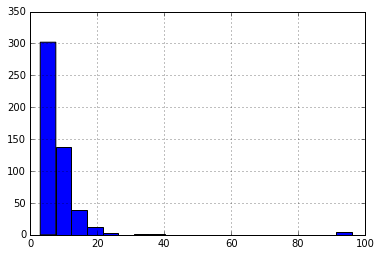

In [221]:
s1.hist(bins=20)

In [222]:
seeds

[2212, 1213, 8221, 7450, 8756, 5493, 4768, 3337, 3795]

In [223]:
if False:
    # very weird
    # different results are given
    epsilons = np.linspace(0.1, 0.9, 9)
    # epsilons = [0.8]
    seeds = [np.random.randint(0, 10000) for i in range(len(epsilons))]
    results = Parallel(n_jobs=-1)(
        delayed(experiment_multiple_rounds)(rounds, g, times_by_source,
                                            infp, fraction,
                                            epsilon=eps,
                                            sampling_method=sampling_method,
                                            seed=seed)
        for eps, seed in zip(epsilons, seeds))

In [224]:
epsilons = np.linspace(0.2, 0.9, 8)
# epsilons = [0.8]
results = []

for eps in tqdm(epsilons):
    result = experiment_multiple_rounds(rounds, g, times_by_source,
                                        infp, fraction,
                                        epsilon=eps,
                                        sampling_method=sampling_method)
    results.append(result)    

100%|██████████| 8/8 [01:43<00:00, 10.41s/it]


In [225]:
list_cnts = [list(zip(*result))[0] for result in results]
means = list(map(np.mean, list_cnts))
medians = list(map(np.median, list_cnts))
df = pd.DataFrame.from_dict({'eps': epsilons,
                             'mean': means, 
                             'median': medians})
df    

,eps,mean,median
0,0.2,42.768,30.0
1,0.3,24.204,17.0
2,0.4,16.548,12.0
3,0.5,11.160,9.0
4,0.6,9.762,7.0
5,0.7,9.010,6.0
6,0.8,9.500,6.0
7,0.9,8.634,6.0


In [226]:
from baselines import baseline_dog_tracker

baseline_cnts = []
for i in range(rounds):
    source, obs_nodes, infection_times, tree = make_input(g, infp, fraction, sampling_method=sampling_method)
    c = baseline_dog_tracker(g, obs_nodes, infection_times)
    baseline_cnts.append(c)

In [227]:
print('mean', np.mean(baseline_cnts))
print('median', np.median(baseline_cnts))

mean 10.26
median 10.0


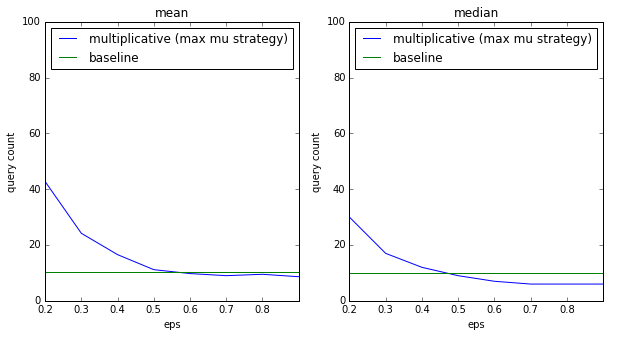

In [228]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax0, ax1 = axes
df.plot(x='eps', y=['mean'], ax=ax0)
ax0.plot([np.mean(baseline_cnts)] * len(epsilons))
ax0.legend(['multiplicative (max mu strategy)', 'baseline'])
ax0.set_ylim(0, 100)
ax0.set_title('mean')
ax0.set_ylabel('query count')

df.plot(x='eps', y=['median'], ax=axes[1])
ax1.plot([np.median(baseline_cnts)] * len(epsilons))
ax1.legend(['multiplicative (max mu strategy)', 'baseline'])
ax1.set_ylim(0, 100)
ax1.set_title('median')
ax1.set_ylabel('query count')

In [229]:
fig.savefig('figs/grid-{}-{}.pdf'.format(sampling_method, fraction))

In [230]:
df.to_pickle('outputs/mwu-{}-{}.pkl'.format(sampling_method, fraction))
import pickle
pd.Series(baseline_cnts).to_pickle('outputs/dog-{}-{}.pkl'.format(sampling_method, fraction))

In [231]:
# summarize result
eps = 0.8
sampling_methods = ['uniform', 'late_nodes']
fraction = 0.02
for s in sampling_methods:
    s1 = pd.read_pickle('outputs/mwu-{}-{}.pkl'.format(s, fraction))
    s2_cnts = pd.read_pickle('outputs/dog-{}-{}.pkl'.format(s, fraction))
    s1[s1['epsilon'] == 0.8]['median'], mp.ms2.cnts